In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/pcamv1 # split 목적

camelyonpatch_level_2_split_test_meta.csv     camelyonpatch_level_2_split_train_x.h5.gz
camelyonpatch_level_2_split_test_x.h5.gz      camelyonpatch_level_2_split_train_y.h5.gz
camelyonpatch_level_2_split_test_y.h5.gz      camelyonpatch_level_2_split_valid_meta.csv
camelyonpatch_level_2_split_train_mask.h5.gz  camelyonpatch_level_2_split_valid_x.h5.gz
camelyonpatch_level_2_split_train_meta.csv    camelyonpatch_level_2_split_valid_y.h5.gz


In [ ]:
import gzip
import shutil
from pathlib import Path

src_dir = Path("/content/drive/MyDrive/pcamv1")
dst_dir = Path("pcam")

dst_dir.mkdir(exist_ok=True) # dst_dir에 파일 생성

for src in src_dir.iterdir():
  if src.suffix == ".gz":
    with gzip.open(src, "rb") as f_in:
      dst = dst_dir / src.stem
      with open(dst, "wb") as f_out:
          shutil.copyfileobj(f_in, f_out)
  else:
    dst = dst_dir / src.name
    shutil.copy2(src, dst)

In [ ]:
import torch
from torchvision.transforms import v2

trn_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(96, 96), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    # 평균과 표준편차로 정규화: pre-trained weight 입장에서 입력 데이터는 늘 정규화 돼있음.
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # test_transforms은 이미지의 특성을 변경하기보다는 모델에 입력할 수 있는 타입으로 변환.
])

In [ ]:
from torchvision.datasets import PCAM
trn_dataset = PCAM(".", split="train", transform=trn_transforms) # .: 현재 폴더
test_dataset = PCAM(".", split="test", transform=test_transforms)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # 평균과 분산 원래대로.
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
inp = np.clip(inp, 0, 1) # 0~1 범위를 넘어가는 값을 처리.
    plt.imshow(inp)
    plt.axis("off")
    plt.show()

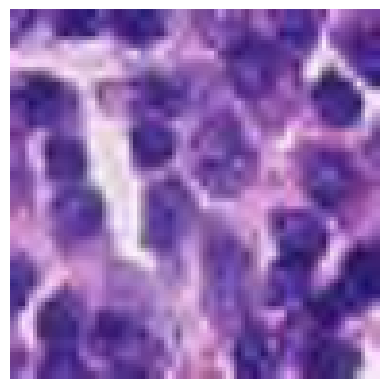

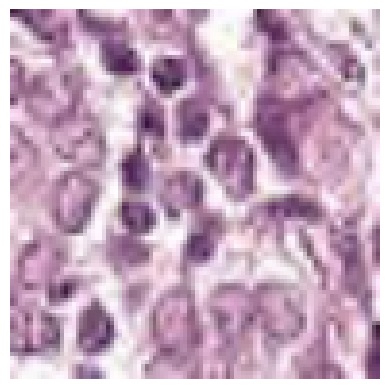

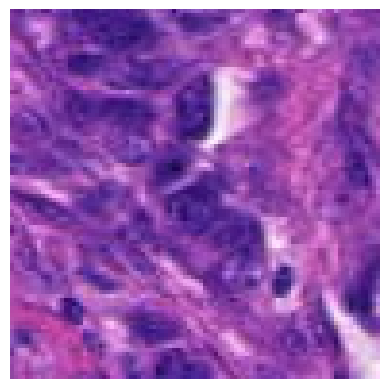

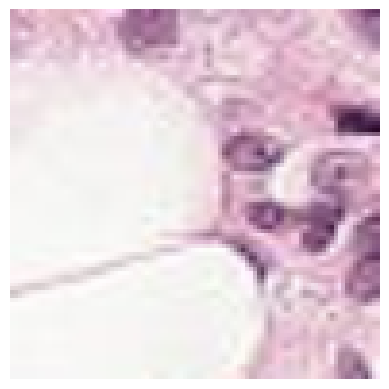

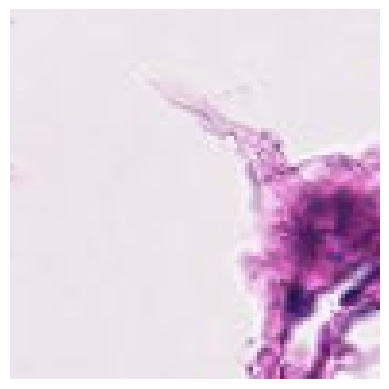

In [ ]:
for i in range(5):
  imshow(trn_dataset[i][0]) # 기본적으로 이미지와 정답을 모두 반환 -> 0번 째 인덱스인 이미지만 가져옴.

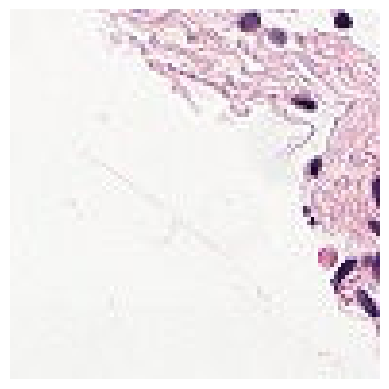

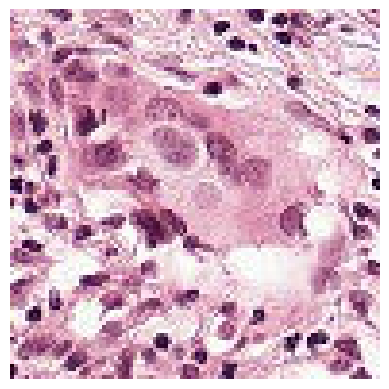

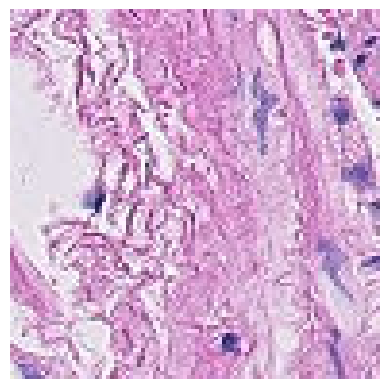

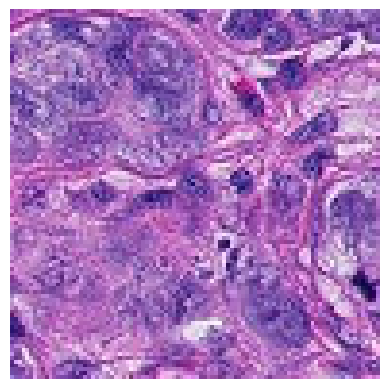

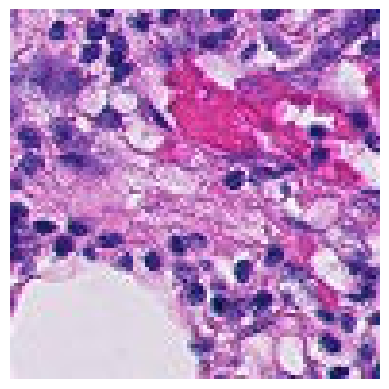

In [ ]:
for i in range(5): # 균일한 세포의 크기(resized 안 함.)
  imshow(test_dataset[i][0])

In [ ]:
# DataLoader 선언, Minibatch의 size = 64, 테스트 데이터는 순서 고정, 훈련 데이터는 매번 다른 순서.
import torch
# shuffle은 병렬 선택 여부, 병렬이라면 몇 개의 process를 사용하는지 결정.
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from tqdm import tqdm

def train(model, criterion, optimizer, trn_loader, test_loader, num_epochs=25):
  for epoch in range(num_epochs):

    model.train()
    trn_loss = 0.0 # mini-batch에 대한 손실이 제대로 예측한 sample 수를 저장하기 위한 변수.
    trn_corrects = 0
    for inputs, labels in tqdm(trn_loader): # patch 이미지의 / 정답
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1) # max 값은 사용 x
      loss = criterion(outputs, labels) # 정답, 손실 계산

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      trn_loss += loss.item() * inputs.size(0)
      trn_corrects += torch.sum(preds == labels.data) # 손실과 맞은 갯수를 이전에 설정한 변수에 더해줌.

    trn_epoch_loss = trn_loss / len(trn_loader.dataset)
    trn_epoch_acc = trn_corrects.double() / len(trn_loader.dataset) # 평균 손실 / 정확도 계산
    print(f"[Train] Loss: {trn_epoch_loss:.4f} Acc: {trn_epoch_acc:.4f}:")

    with torch.no_grad(): # 기울기 계산 x
      model.eval() # 평가임을 선언.
      test_loss = 0.0
      test_corrects = 0
      for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

      test_epoch_loss = test_loss / len(test_loader.dataset)
      test_epoch_acc = test_corrects.double() / len(test_loader.dataset)
      print(f"[Test] Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}:")

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 마지막 FC Layer를 2개의 클래스에 대해 예측하도록 선언.
# FC Layer는 pre-trained weights를 사용 x

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train(model, criterion, optimizer, trn_loader, test_loader, num_epochs=10)

100%|██████████| 4096/4096 [14:41<00:00,  4.65it/s]


[Train] Loss: 0.4512 Acc: 0.7958:


100%|██████████| 512/512 [00:57<00:00,  8.89it/s]


[Test] Loss: 0.8422 Acc: 0.6474:


100%|██████████| 4096/4096 [18:36<00:00,  3.67it/s]


[Train] Loss: 0.3613 Acc: 0.8407:


100%|██████████| 512/512 [00:57<00:00,  8.83it/s]


[Test] Loss: 0.8296 Acc: 0.6930:


100%|██████████| 4096/4096 [18:17<00:00,  3.73it/s]


[Train] Loss: 0.3246 Acc: 0.8607:


100%|██████████| 512/512 [00:59<00:00,  8.64it/s]


[Test] Loss: 0.6684 Acc: 0.7519:


100%|██████████| 4096/4096 [18:21<00:00,  3.72it/s]


[Train] Loss: 0.2978 Acc: 0.8743:


100%|██████████| 512/512 [00:57<00:00,  8.84it/s]


[Test] Loss: 0.6339 Acc: 0.7505:


100%|██████████| 4096/4096 [18:20<00:00,  3.72it/s]


[Train] Loss: 0.2813 Acc: 0.8822:


100%|██████████| 512/512 [00:58<00:00,  8.80it/s]


[Test] Loss: 0.6621 Acc: 0.7554:


100%|██████████| 4096/4096 [18:10<00:00,  3.76it/s]


[Train] Loss: 0.2679 Acc: 0.8884:


100%|██████████| 512/512 [00:58<00:00,  8.73it/s]


[Test] Loss: 0.8425 Acc: 0.7288:


100%|██████████| 4096/4096 [18:24<00:00,  3.71it/s]


[Train] Loss: 0.2596 Acc: 0.8932:


100%|██████████| 512/512 [00:58<00:00,  8.70it/s]


[Test] Loss: 0.6723 Acc: 0.7563:


100%|██████████| 4096/4096 [18:26<00:00,  3.70it/s]


[Train] Loss: 0.2514 Acc: 0.8972:


100%|██████████| 512/512 [00:57<00:00,  8.87it/s]


[Test] Loss: 0.7595 Acc: 0.7268:


100%|██████████| 4096/4096 [18:11<00:00,  3.75it/s]


[Train] Loss: 0.2471 Acc: 0.8985:


100%|██████████| 512/512 [01:04<00:00,  7.97it/s]


[Test] Loss: 1.0603 Acc: 0.7330:


100%|██████████| 4096/4096 [18:41<00:00,  3.65it/s]


[Train] Loss: 0.2423 Acc: 0.9005:


100%|██████████| 512/512 [00:58<00:00,  8.75it/s]

[Test] Loss: 0.8703 Acc: 0.7166:


In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/model_pcam.pth") # 모델 저장
model.load_state_dict(torch.load("/content/drive/MyDrive/model_pcam.pth"))# 저장된 파라미터 불러오기.

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                imshow(inputs.cpu().data[j]) # 시각화 할 데이터는 CPU에 있어야 함.
                print(f'predicted: {preds[j]}')
                print(f"label: {labels[j]}")

                if images_so_far == num_images:
                    return

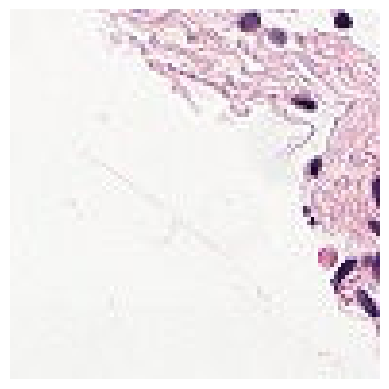

predicted: 0
label: 0


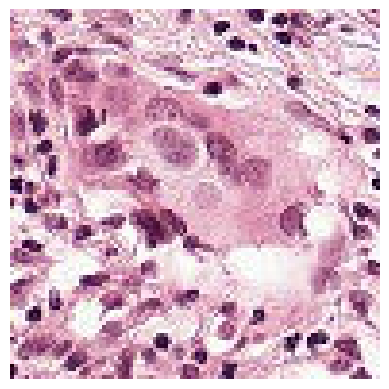

predicted: 0
label: 1


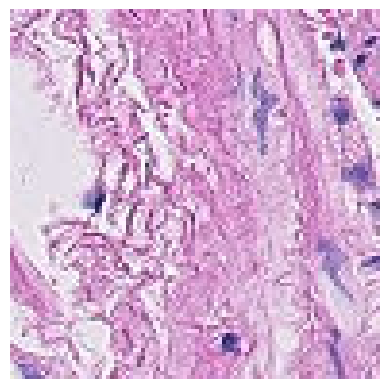

predicted: 1
label: 0


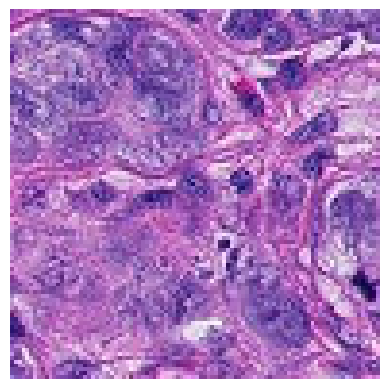

predicted: 1
label: 1


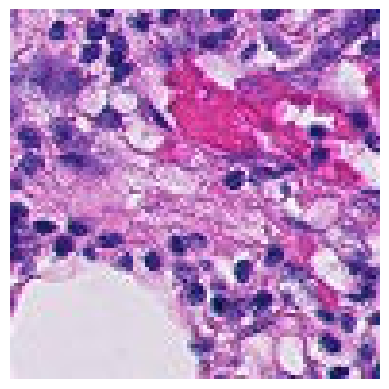

predicted: 0
label: 1


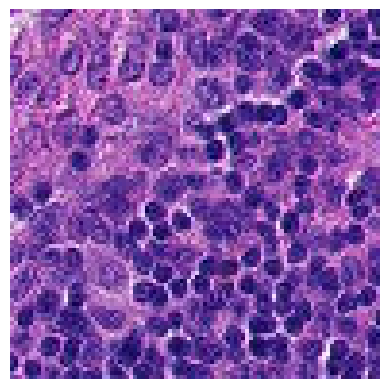

predicted: 0
label: 0


In [ ]:
visualize_model(model)